In [6]:
import pandas as pd
import numpy as np
import ccxt
import datetime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats

# 连接Binance API
exchange = ccxt.binance({
    'enableRateLimit': True,
})

def fetch_ohlcv_data(symbol, timeframe, since, limit=1000):
    try:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

# 获取从2021年1月至今的数据
start_date = datetime(2021, 1, 1)
end_date = datetime.now()
symbol = 'BTC/USDT'
timeframe = '1h'

# 获取数据
dfs = []
current_date = start_date
while current_date < end_date:
    df = fetch_ohlcv_data(symbol, timeframe, exchange.parse8601(current_date.isoformat()))
    if df is not None:
        dfs.append(df)
    current_date += timedelta(days=30)

# 合并数据
df = pd.concat(dfs, ignore_index=True)
df = df.drop_duplicates()
df = df.sort_values('timestamp')

In [7]:
def calculate_vwap(df, window=24):
    typical_price = (df['close'] + df['high'] + df['low']) / 3
    df['vwap'] = (typical_price * df['volume']).rolling(window=window).sum() / df['volume'].rolling(window=window).sum()
    return df

def calculate_alphas(df):
    # 计算VWAP
    df = calculate_vwap(df)
    
    # Alpha A: close - vwap
    df['alpha_A'] = np.sqrt(df['high'] * df['low']) - df['vwap']
    
    # Alpha B: −1 * ((low - close) * (open^5))/((low - high) * (close^5))
    df['alpha_B'] = -1 * ((df['low'] - df['close']) * (df['open'] ** 5)) / ((df['low'] - df['high']) * (df['close'] ** 5))

    # Alpha C: (close - open)/(high - low)+0.001
    denominator = np.maximum(df['high'] - df['low'], 0.0001)
    df['alpha_C'] = (df['close'] - df['open']) / denominator + 0.001
    
    return df

# 计算Alpha因子
df = calculate_alphas(df)

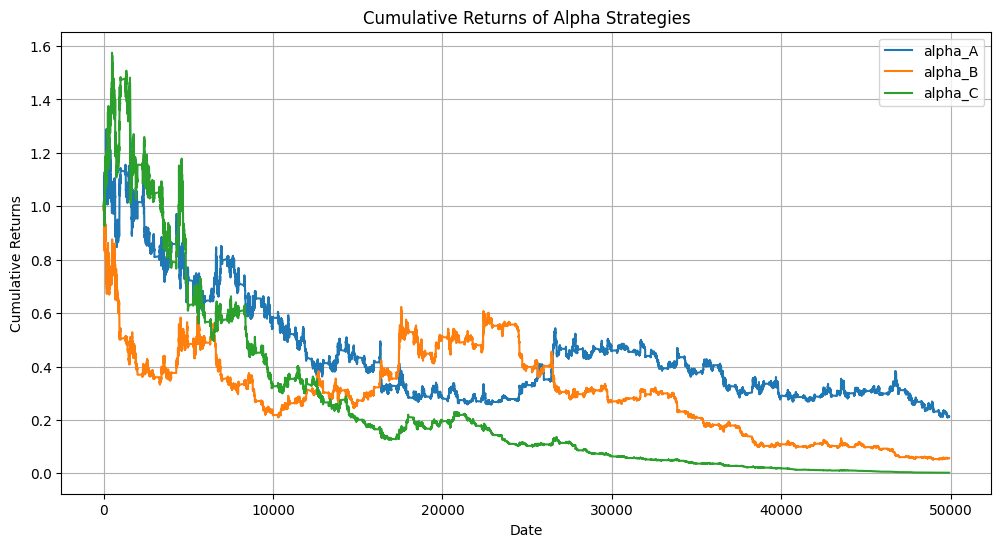


Performance metrics for alpha_A:
Annual Return: -100.00%
Sharpe Ratio: nan
Maximum Drawdown: -83.73%
Calmar Ratio: -1.19

Performance metrics for alpha_B:
Annual Return: -100.00%
Sharpe Ratio: nan
Maximum Drawdown: -94.81%
Calmar Ratio: -1.05

Performance metrics for alpha_C:
Annual Return: -100.00%
Sharpe Ratio: nan
Maximum Drawdown: -99.86%
Calmar Ratio: -1.00


In [8]:
def generate_signals(df, alpha_name, threshold=0):
    """基于alpha值生成交易信号"""
    signals = pd.Series(0, index=df.index)
    signals[df[alpha_name] > threshold] = 1  # 做多信号
    signals[df[alpha_name] < -threshold] = -1  # 做空信号
    return signals


def backtest(df, signals, trading_cost=0.0001):
    """回测函数"""
    returns = df['close'].pct_change()
    strategy_returns = signals.shift(1) * returns - abs(signals.diff()) * trading_cost
    cumulative_returns = (1 + strategy_returns).cumprod()
    
    # 将时间索引转换为日期格式
    strategy_returns.index = pd.to_datetime(strategy_returns.index)
    daily_returns = strategy_returns.resample('D').sum()  # 改用resample来计算日收益
    
    # 计算性能指标
    annual_return = (cumulative_returns.iloc[-1] ** (252/len(daily_returns)) - 1)
    sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std()
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else np.inf
    
    return {
        'cumulative_returns': cumulative_returns,
        'annual_return': annual_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio
    }

# 完整的回测代码
def run_backtest():
    # 对每个alpha因子进行回测
    alphas = ['alpha_A', 'alpha_B', 'alpha_C']
    results = {}

    for alpha in alphas:
        signals = generate_signals(df, alpha)
        results[alpha] = backtest(df, signals)

    # 绘制结果
    plt.figure(figsize=(12, 6))
    for alpha in alphas:
        plt.plot(results[alpha]['cumulative_returns'], label=alpha)
    plt.legend()
    plt.title('Cumulative Returns of Alpha Strategies')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.grid(True)
    plt.show()

    # 打印性能指标
    for alpha in alphas:
        print(f"\nPerformance metrics for {alpha}:")
        print(f"Annual Return: {results[alpha]['annual_return']:.2%}")
        print(f"Sharpe Ratio: {results[alpha]['sharpe_ratio']:.2f}")
        print(f"Maximum Drawdown: {results[alpha]['max_drawdown']:.2%}")
        print(f"Calmar Ratio: {results[alpha]['calmar_ratio']:.2f}")
    
    return results

# 运行回测
results = run_backtest()

In [9]:
def combine_signals(df, weights=None):
    """组合多个alpha信号"""
    if weights is None:
        weights = {'alpha_A': 1/3, 'alpha_B': 1/3, 'alpha_C': 1/3}
    
    combined_signal = pd.Series(0, index=df.index)
    for alpha, weight in weights.items():
        alpha_signal = generate_signals(df, alpha)
        combined_signal += weight * alpha_signal
    
    return np.sign(combined_signal)

# 运行组合策略回测
combined_signals = combine_signals(df)
combined_results = backtest(df, combined_signals)

# 打印组合策略结果
print("\nCombined Strategy Performance:")
print(f"Annual Return: {combined_results['annual_return']:.2%}")
print(f"Sharpe Ratio: {combined_results['sharpe_ratio']:.2f}")
print(f"Maximum Drawdown: {combined_results['max_drawdown']:.2%}")
print(f"Calmar Ratio: {combined_results['calmar_ratio']:.2f}")


Combined Strategy Performance:
Annual Return: -100.00%
Sharpe Ratio: nan
Maximum Drawdown: -99.17%
Calmar Ratio: -1.01
